# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [3]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [4]:
feature_names = []
with open('mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print('Loaded feature names:', len(feature_names))

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [5]:
X, Y = [], []

with open('mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print(train_data.shape, test_data.shape)

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

In [6]:
def P1():
## STUDENT START ###

    #run PCA
    pca = PCA()
    pca.fit(train_data)
    
    # Show fraction of the total variance explained by first k principal components
    for k in range(50):
        print(k+1, "component:", pca.explained_variance_ratio_[k])

## STUDENT END ###

P1()

1 component: 0.164043312793
2 component: 0.133234788694
3 component: 0.101734565221
4 component: 0.0706335643499
5 component: 0.038666463507
6 component: 0.0368080430749
7 component: 0.0312823910267
8 component: 0.0273373735275
9 component: 0.0261649046891
10 component: 0.0223094256785
11 component: 0.0204817295367
12 component: 0.0186833065909
13 component: 0.0173442203292
14 component: 0.016843606457
15 component: 0.0151881879472
16 component: 0.0150861842811
17 component: 0.0142913350365
18 component: 0.0141201263122
19 component: 0.013250447394
20 component: 0.0114637895087
21 component: 0.0107106584684
22 component: 0.0106574664421
23 component: 0.0104096717303
24 component: 0.00993698526416
25 component: 0.00908069864623
26 component: 0.00869326230294
27 component: 0.00795616735521
28 component: 0.00775824551877
29 component: 0.00737569674956
30 component: 0.00700275962221
31 component: 0.00641233151157
32 component: 0.00614513432766
33 component: 0.00572344996832
34 component: 0

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

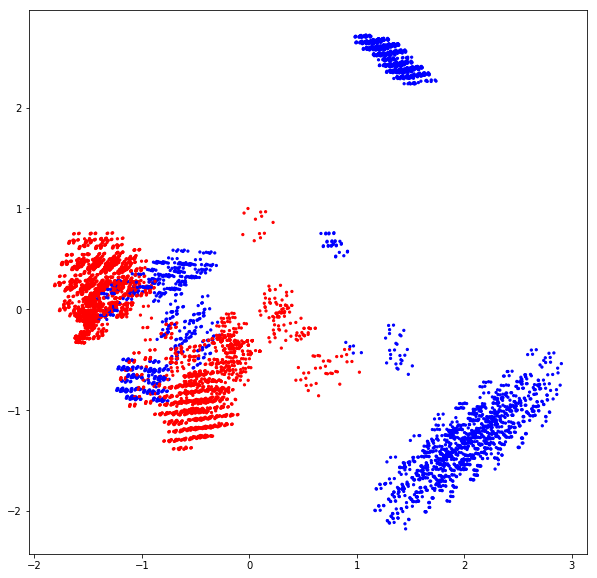

In [7]:
def P2():
## STUDENT START ###

    # Run PCA with 2 components
    pca = PCA(n_components=2)
    pca.fit(train_data)
    new_pca_features = pca.transform(train_data)

    # Set colors: blue for positive (poisonous) and red for negative (non-poisonous)
    colors = []
    for i in range(len(train_labels)):
        if train_labels[i] > 0:
            colors.append('blue')
        else:
            colors.append('red')
    
    # Scatterplot the projected data
    plt.figure(figsize=(10, 10))
    plt.scatter(new_pca_features[:, 0], new_pca_features[:, 1], c=colors, s=5)
    plt.show()


## STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

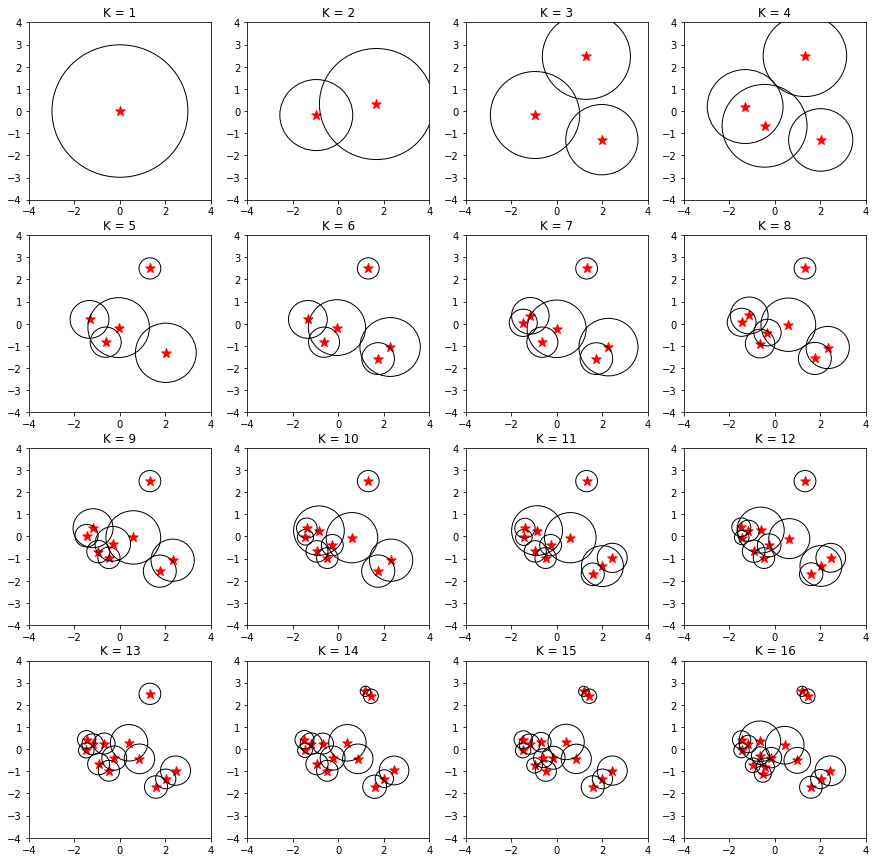

In [8]:
def P3():
## STUDENT START ###

    # Set 4X4 plots
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize = (15, 15))
    
    # Run PCA with 2 components
    pca = PCA(n_components=2)
    pca.fit(train_data)
    new_pca_features = pca.transform(train_data)

    # Run KMeans with k=1 to k=16
    for k in range(0,16):
        
        # KMeans clustering
        km = KMeans(n_clusters=k+1, init='k-means++')
        clstrs = km.fit(new_pca_features)
        
        # Define subplot
        ax = axes[int(k/4), int(k%4)]
        
        # Create circle for each cluster
        for i in range(k+1):
            
            # Find distance between each point in each cluster and centroid
            # Distance list
            dists = []
            for sample in range(new_pca_features.shape[0]):
                if clstrs.labels_[sample] == i:
                    distance = np.linalg.norm(new_pca_features[sample]-clstrs.cluster_centers_[i])
                    dists.append(distance)
                    
                else:
                    dists.append(0)
            
            # Plot a circle for each cluster
            circle = plt.Circle((clstrs.cluster_centers_[i,0], clstrs.cluster_centers_[i,1]), max(dists), fill=False)
            ax.add_artist(circle)
        
        # Mark cetroids
        ax.scatter(clstrs.cluster_centers_[:,0], clstrs.cluster_centers_[:,1], marker='*', c='red', s=100)
        
        # Other subplot attributes
        ax.set_title("K = " + str(k+1))
        ax.set_ylim(-4, 4)
        ax.set_xlim(-4, 4)
    
    plt.show()
## STUDENT END ###

P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/Users/pham/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1518: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


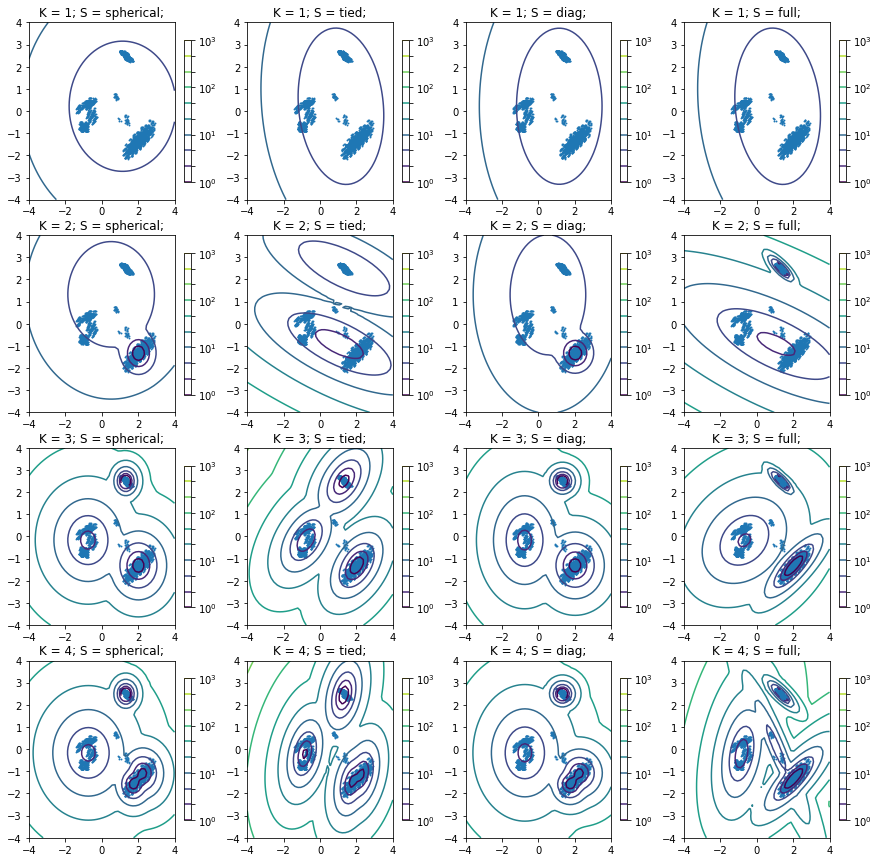

In [15]:
def P4():
## STUDENT START ###

    # Run PCA with 2 components
    pca = PCA(n_components=2)
    pca.fit(train_data)
    new_pca_features = pca.transform(train_data)[np.argwhere(train_labels > 0)[:,0],:]
    
    # Lists for component size and covariance type
    comps = [1,2,3,4]
    structures = ['spherical', 'tied', 'diag', 'full']
    
    # Define figure size
    plt.figure(figsize=(15, 15))
    
    # Plot 4X4 contour plots for each component size, covariance type combination
    i = 0
    for comp in comps:
        for structure in structures:
            i += 1
            
            # Train Gaussian Mixture Model
            gm = GaussianMixture(n_components=comp, covariance_type=structure)
            gm.fit(new_pca_features)
            
            # Display predicted scores by the model as a contour plot
            x = np.linspace(-4., 4.)
            y = np.linspace(-4., 4.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -gm.score_samples(XX)
            Z = Z.reshape(X.shape)

            p = plt.subplot(len(comps), len(structures), i)
            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            p.scatter(new_pca_features[:, 0], new_pca_features[:, 1], .8)
            plt.title("K = " + str(comp) + "; S = " + str(structure) + ";")
## STUDENT END ###
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [10]:
def P5():
## STUDENT START ###

    # Run PCA for train data with 2 components
    pca = PCA(n_components=2)
    pca.fit(train_data)
    pca_train_pos = pca.transform(train_data)[np.argwhere(train_labels > 0)[:,0],:]
    pca_train_neg = pca.transform(train_data)[np.argwhere(train_labels == 0)[:,0],:]
    
    # Run PCA for test data with 2 components
    pca = PCA(n_components=2)
    pca.fit(test_data)
    pca_test = pca.transform(test_data)
    
    # Train Gaussian Mixture Model for positives
    gm_mod_pos = GaussianMixture(n_components=4, covariance_type='full')
    gm_mod_pos.fit(pca_train_pos)
    pos_prob = gm_mod_pos.score_samples(pca_test)
    
    # Train Gaussian Mixture Model for negatives
    gm_mod_neg = GaussianMixture(n_components=4, covariance_type='full')
    gm_mod_neg.fit(pca_train_neg)
    neg_prob = gm_mod_neg.score_samples(pca_test)
    
    # Predict test examples using log probabilities
    correct = 0
    for sample in range(len(test_labels)):
        if pos_prob[sample] > neg_prob[sample]:
            pred = 1
        else:
            pred = 0

        if pred == test_labels[sample]:
            correct += 1
    
    print("Accuracy is", correct/len(pca_test)*100)
## STUDENT END ###

P5()

Accuracy is 92.79359430604983


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [12]:
def P6():
## STUDENT START ###


# Help function to calculate model accuracy using given parameters
    def gmm_accuracy(pca_comp, gmm_comp, cov):
        
        # Run PCA for train data
        pca_mod = PCA(n_components=pca_comp)
        pca_mod.fit(train_data)
        pca_train_pos = pca_mod.transform(train_data)[np.argwhere(train_labels > 0)[:,0],:]
        pca_train_neg = pca_mod.transform(train_data)[np.argwhere(train_labels == 0)[:,0],:]

        # Run PCA for test data
        pca_mod = PCA(n_components=pca_comp)
        pca_mod.fit(test_data)
        pca_test = pca_mod.transform(test_data)
    
        # Train Gaussian Mixture Model for positives
        gm_mod_pos = GaussianMixture(n_components=gmm_comp, covariance_type=cov)
        gm_mod_pos.fit(pca_train_pos)
        pos_prob = gm_mod_pos.score_samples(pca_test)

        # Train Gaussian Mixture Model for negatives
        gm_mod_neg = GaussianMixture(n_components=gmm_comp, covariance_type=cov)
        gm_mod_neg.fit(pca_train_neg)
        neg_prob = gm_mod_neg.score_samples(pca_test)

        # Predict test examples using log probabilities
        correct = 0
        for sample in range(len(test_labels)):
            if pos_prob[sample] > neg_prob[sample]:
                predictor = 1
            else:
                predictor = 0

            if predictor == test_labels[sample]:
                correct += 1

        return(correct/len(pca_test)*100)

    # Helper function calculating number of parameters to predict
    def params_number(pca_comp, gmm_comp, cov):
        if cov == 'diag':
            return ((pca_comp + pca_comp) * gmm_comp) * 2
        elif cov == 'spherical':
            return ((pca_comp + 1) * gmm_comp) * 2
        elif cov == 'tied':
            return (pca_comp * gmm_comp + sum(range(1,pca_comp+1))) * 2
        else:
            return ((pca_comp + sum(range(1,pca_comp+1))) * gmm_comp) * 2

    # Covariance types
    structures = ['spherical', 'tied', 'diag', 'full']
    
    # Initialize max values
    max_accuracy = 0
    max_pca_comp = 1
    max_gmm_comp = 1
    best_structure = ''
    
    # Find a model whcih gives the best accuracy when varying PCA components, GMM components, and covariance structures
    for pca_comp in range(1,50):
        for gmm_comp in range(1,50):
            for cov in structures:
                if params_number(pca_comp, gmm_comp, cov) <= 50:
                    accuracy = gmm_accuracy(pca_comp, gmm_comp, cov)
                    if accuracy > max_accuracy:
                        max_accuracy = accuracy
                        max_pca_comp = pca_comp
                        max_gmm_comp = gmm_comp
                        best_structure = cov

    print("The best model has", max_pca_comp, "PCA components,", max_gmm_comp, "GMM component")
    print("with accuracy", max_accuracy)
    
## STUDENT END ###

P6()

The best model has 3 PCA components, 5 GMM component
with accuracy 94.21708185053382
